In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from swarm_sim import *

%matplotlib inline 

## Load the data and format it as Swarm object

In [3]:
PATH = '..\data\Traces_Nanosatellites\\track_'
satellites = {}

with tqdm(total=100, desc='Extracting data') as pbar:
    for i in range(0,100):
        df = pd.read_csv(PATH+str(i)+'.csv', sep=',', header=0)
        df['coords'] = ['x','y','z']
        satellites[i] = df.set_index('coords', drop=True)
        pbar.update(1)
    
DURATION = satellites[0].columns.tolist()
NB_NODES = 100

satellites[0].head()

Extracting data: 100%|██████████| 100/100 [01:44<00:00,  1.05s/it]


,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
coords,,,,,,,,,,,,,,,,,,,,,
x,-4.850747e+05,-4.937755e+05,-5.024536e+05,-5.111086e+05,-5.197401e+05,-5.283476e+05,-5.369309e+05,-5.454894e+05,-5.540229e+05,-5.625310e+05,...,1.490967e+06,1.494274e+06,1.497573e+06,1.500865e+06,1.504149e+06,1.507425e+06,1.510693e+06,1.513954e+06,1.517206e+06,1.520451e+06
y,-7.066530e+05,-7.201117e+05,-7.335372e+05,-7.469290e+05,-7.602864e+05,-7.736088e+05,-7.868957e+05,-8.001464e+05,-8.133603e+05,-8.265368e+05,...,2.218138e+06,2.223313e+06,2.228477e+06,2.233629e+06,2.238769e+06,2.243898e+06,2.249015e+06,2.254120e+06,2.259214e+06,2.264296e+06
z,-2.026363e+06,-2.019625e+06,-2.012795e+06,-2.005871e+06,-1.998855e+06,-1.991747e+06,-1.984548e+06,-1.977257e+06,-1.969876e+06,-1.962403e+06,...,3.692429e+06,3.686602e+06,3.680756e+06,3.674890e+06,3.669006e+06,3.663103e+06,3.657180e+06,3.651239e+06,3.645278e+06,3.639299e+06


In [4]:
swarm_data = {}
CHUNKS = 1800     # Number of timestamps to analyse

with tqdm(total = CHUNKS, desc = 'Converting to Swarm') as pbar:
    for t in range(CHUNKS):
        swarm_data[int(t)] = Swarm(
            connection_range=30000, 
            nodes=[Node(id, node[str(t)].x, node[str(t)].y, node[str(t)].z) for id,node in satellites.items()]
            )
        pbar.update(1)

print(swarm_data[0])

Converting to Swarm: 100%|██████████| 1800/1800 [00:11<00:00, 160.16it/s]

Swarm of 100 node(s), connection range: 30000


## Network initialization

In [5]:
def compute_neighbor_matrix(swarm_chunk, connection_range=None):
    with tqdm(total=len(swarm_chunk.keys()), desc='Computing Neighbor matrix') as pbar:
        for swarm in swarm_chunk.values():
            swarm.neighbor_matrix(connection_range)
            pbar.update(1)


compute_neighbor_matrix(swarm_data, connection_range=30000)

Computing Neighbor matrix: 100%|██████████| 1800/1800 [00:12<00:00, 148.03it/s]


## 1. Epidemic propagation (percolation analysis)

In [11]:
def propagate_flooding(swarms, src_id=0, start=0, stop=CHUNKS, destination=None, debug=True):
    for t in range(start, stop):
        swarms[t].clear_caches()  
    percolation = {}
        
    src = swarms[start].get_node_by_id(src_id)
    pkt = Packet(src_id=src.id)
    src.add_to_cache(pkt) # Initial message bearer
    pkt_bearers = [src.id]
    prev_caches = swarms[start].copy_caches()
    percolation[0] = 0
    
    if not destination:
        destination = [n.id for n in swarms[0].nodes]
    
    for t in range(start+1, stop):
        current_caches = prev_caches
        swarms[t].update_caches(current_caches)
        new_bearers = swarms[t].flooding(pkt, pkt_bearers)
        if new_bearers != pkt_bearers:
            nodes_reached = [n.id for n in swarms[t].nodes if pkt.is_in(n.cache)]
            if debug:
                print(f'\n==================== TIME T={t} ====================\n')
                print(f'Packet sent by {len(pkt_bearers)} node(s): ', pkt_bearers)
                print(f'Packet received by {len(new_bearers)} node(s): ', new_bearers)
                print(f'Reached {len(nodes_reached)}%  of the network.')
            percolation[t] = len(nodes_reached)
        if pkt.has_reached(swarms[t], destination): #All nodes have received a message
            print(f'Transmission completed in {t} steps.')
            break
        else:
            pkt_bearers = new_bearers
            prev_caches = swarms[t].copy_caches()
        
    unreached = [n.id for n in swarms[stop-1].nodes if pkt.is_in(n.cache)==False] 
    print(f'\nUnreachable node(s) from src {src_id}:\n', unreached)
    percolation[stop-1] = len(nodes_reached)
    return percolation

In [12]:
sid = 35 #17, 22, 54
perco = propagate_flooding(swarm_data, src_id=sid, stop=1800, debug=True)


==================== TIME T=1 ====================

Packet sent by 1 node(s):  [35]
Packet received by 10 node(s):  [96, 44, 48, 49, 80, 51, 20, 52, 28, 29]
Reached 11%  of the network.

==================== TIME T=2 ====================

Packet sent by 10 node(s):  [96, 44, 48, 49, 80, 51, 20, 52, 28, 29]
Packet received by 11 node(s):  [64, 97, 2, 98, 5, 41, 10, 46, 24, 58, 59]
Reached 22%  of the network.

==================== TIME T=3 ====================

Packet sent by 11 node(s):  [64, 97, 2, 98, 5, 41, 10, 46, 24, 58, 59]
Packet received by 25 node(s):  [7, 9, 11, 13, 17, 19, 25, 27, 31, 33, 40, 42, 50, 55, 67, 70, 71, 73, 78, 81, 84, 89, 90, 91, 94]
Reached 47%  of the network.

==================== TIME T=4 ====================

Packet sent by 25 node(s):  [7, 9, 11, 13, 17, 19, 25, 27, 31, 33, 40, 42, 50, 55, 67, 70, 71, 73, 78, 81, 84, 89, 90, 91, 94]
Packet received by 14 node(s):  [0, 1, 75, 14, 79, 18, 83, 82, 22, 87, 88, 57, 63, 95]
Reached 61%  of the network.

======

In [13]:
perco_src = {}
for n in swarm_data[0].nodes:
    perco_src[n.id] = propagate_flooding(swarm_data, src_id=n.id, stop=1800, debug=False)


Unreachable node(s) from src 0:
 [3, 16, 34, 36, 37, 53, 54, 85, 86, 99]

Unreachable node(s) from src 1:
 [3, 16, 34, 36, 37, 53, 54, 85, 86, 99]

Unreachable node(s) from src 2:
 [3, 16, 34, 36, 37, 53, 54, 85, 86, 99]

Unreachable node(s) from src 3:
 [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]

Unreachable node(s) from src 4:
 [3, 16, 34, 36, 37, 53, 54, 85, 86, 99]

Unreachable node(s) from src 5:
 [3, 16, 34, 36, 37, 53, 54, 85, 86, 99]

Unreachable node(s) from src 6:
 [3, 16, 34, 36, 37, 53, 54, 85, 86, 99]

Unreachable node(s) from src 7:
 [3, 16, 34, 36, 37, 53, 54, 85, 86, 99]

Unreachable node(s) from src 8:
 [3, 16, 34, 36, 37, 53, 54

Text(0.5, 1.0, 'Evolution of the epidemic propagation from all sources')

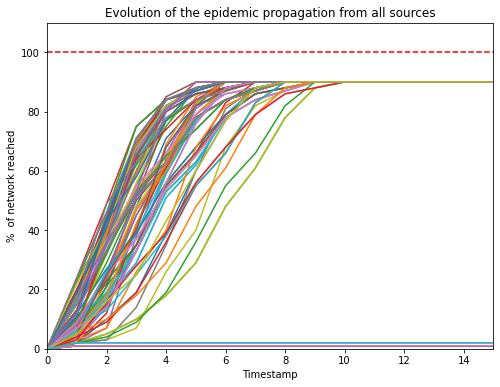

In [14]:
plt.figure(figsize=(8,6))
for sid, perco in perco_src.items():
    plt.plot(perco.keys(), perco.values(), label=str(sid))
plt.axhline(y=100, xmin=0, xmax=100, ls='--', c='red', label='Max')
plt.xlabel('Timestamp')
plt.ylabel('%  of network reached')
plt.xlim(0,15)
plt.ylim(0,110)
#plt.legend(loc='lower right')
plt.title(f'Evolution of the epidemic propagation from all sources')

## 2. Percolation analysis by group (MDRW division)

In [57]:
def propagate_multicast(swarms, src_id=0, start=0, stop=CHUNKS, destination=None, debug=True):
    for t in range(start, stop):
        swarms[t].clear_caches()  
    percolation = {}
        
    src = swarms[start].get_node_by_id(src_id)
    pkt = Packet(src_id=src.id)
    src.add_to_cache(pkt) # Initial message bearer
    pkt_bearers = [src.id]
    prev_caches = swarms[start].copy_caches()
    percolation[start] = len(pkt_bearers)/len(destination)*100
    
    if not destination:
        destination = [n.id for n in swarms[0].nodes]
    
    for t in range(start+1, stop):
        current_caches = prev_caches
        swarms[t].update_caches(current_caches)
        new_bearers = swarms[t].flooding(pkt, pkt_bearers)
        if new_bearers != pkt_bearers:
            nodes_reached = [n.id for n in swarms[t].nodes if pkt.is_in(n.cache)]
            members = [nid for nid in nodes_reached if nid in destination]
            if debug:
                print(f'\n==================== TIME T={t} ====================\n')
                print(f'Packet sent by {len(pkt_bearers)} node(s): ', pkt_bearers)
                print(f'Packet received by {len(new_bearers)} node(s): ', new_bearers)
                print(f'Packet received by {len(members)} group member(s): ', members)
                print(f'Reached {len(members)/len(destination)*100}%  of the group.')
            percolation[t] = len(members)/len(destination)*100
        if pkt.has_reached(swarms[t], destination): #All nodes have received a message
            print(f'Transmission completed in {t-start} steps.')
            break
        else:
            pkt_bearers = new_bearers
            prev_caches = swarms[t].copy_caches()
        
    unreached = [n.id for n in swarms[stop-1].nodes if pkt.is_in(n.cache)==False] 
    unreached_members = [nid for nid in unreached if nid in destination]
    print(f'\nUnreachable node(s) from src {src_id}:\n', unreached_members)
    percolation[stop-1] = len(members)/len(destination)*100
    return percolation

In [66]:
start = 810 # 810, 484, 1556

nb_groups = 10 
swarm_data[start].reset_groups()

swarm_data[start].MDRW(n=nb_groups, s=10)
groups = {}
for node in swarm_data[start].nodes:
    groups[node.id] = node.group

for t, swarm in swarm_data.items():
    for n in swarm.nodes:
        n.group = groups[n.id]

In [67]:
node_groups = {}
for i in range(nb_groups):
    node_groups[i] = [n.id for n in swarm_data[0].nodes if n.group==i]

perco_group = {}
for group_id, group in node_groups.items():
    perco_node = {}
    for nid in group:
        perco_node[nid] = propagate_multicast(swarm_data, src_id=nid, start=start, stop=1800, destination=group, debug=False)
    perco_group[group_id] = perco_node

Transmission completed in 6 steps.

Unreachable node(s) from src 30:
 [30, 31, 34, 42, 58, 66, 69, 72, 89, 90]
Transmission completed in 7 steps.

Unreachable node(s) from src 31:
 [30, 31, 34, 42, 58, 66, 69, 72, 89, 90]
Transmission completed in 7 steps.

Unreachable node(s) from src 34:
 [30, 31, 34, 42, 58, 66, 69, 72, 89, 90]
Transmission completed in 6 steps.

Unreachable node(s) from src 42:
 [30, 31, 34, 42, 58, 66, 69, 72, 89, 90]
Transmission completed in 6 steps.

Unreachable node(s) from src 58:
 [30, 31, 34, 42, 58, 66, 69, 72, 89, 90]
Transmission completed in 6 steps.

Unreachable node(s) from src 66:
 [30, 31, 34, 42, 58, 66, 69, 72, 89, 90]
Transmission completed in 6 steps.

Unreachable node(s) from src 69:
 [30, 31, 34, 42, 58, 66, 69, 72, 89, 90]
Transmission completed in 7 steps.

Unreachable node(s) from src 72:
 [30, 31, 34, 42, 58, 66, 69, 72, 89, 90]
Transmission completed in 6 steps.

Unreachable node(s) from src 89:
 [30, 31, 34, 42, 58, 66, 69, 72, 89, 90]
T

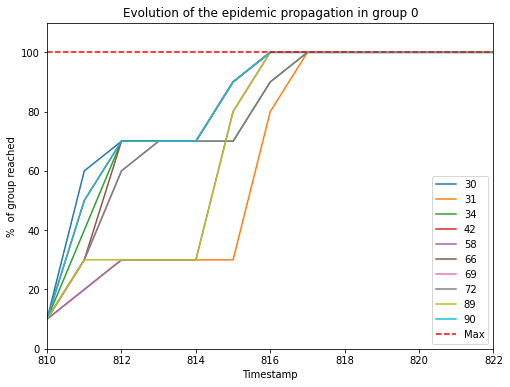

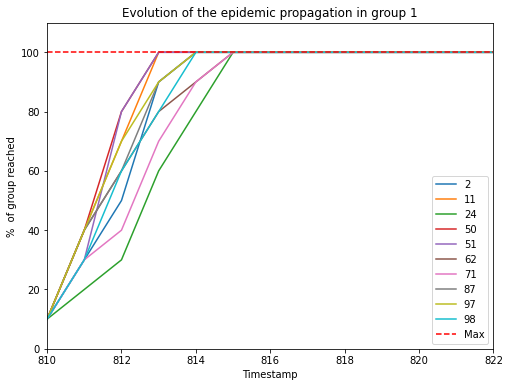

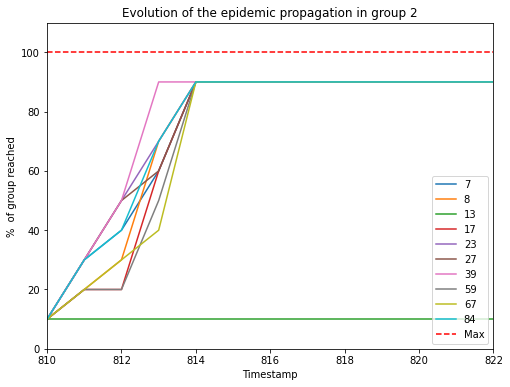

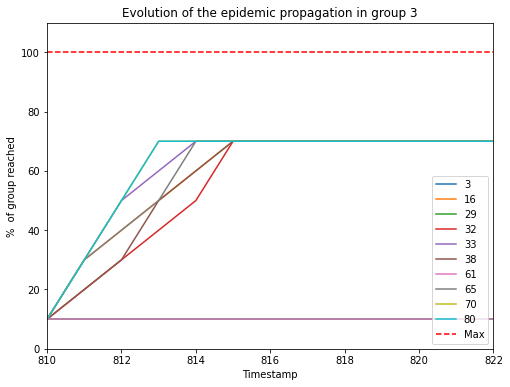

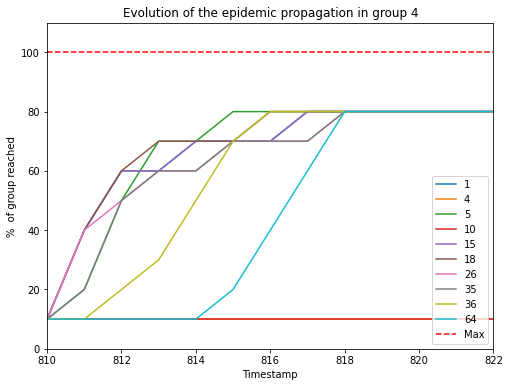

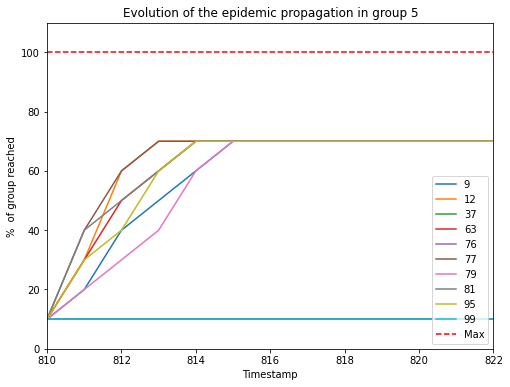

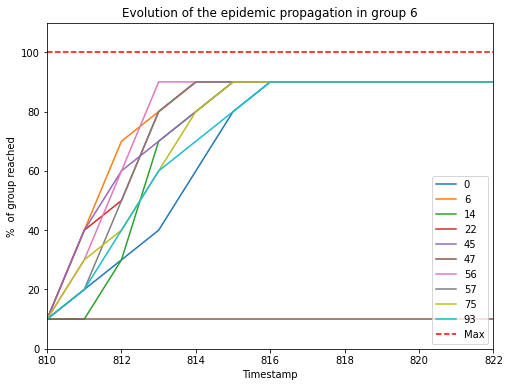

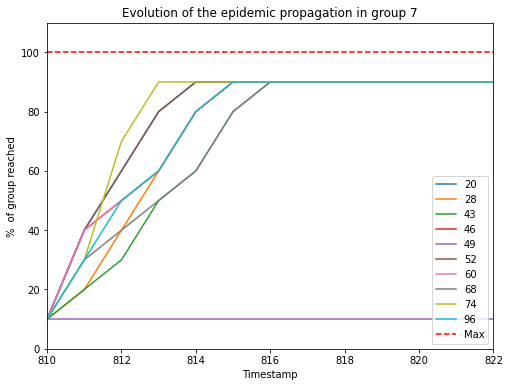

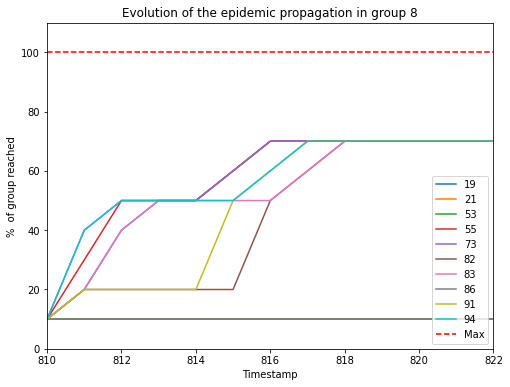

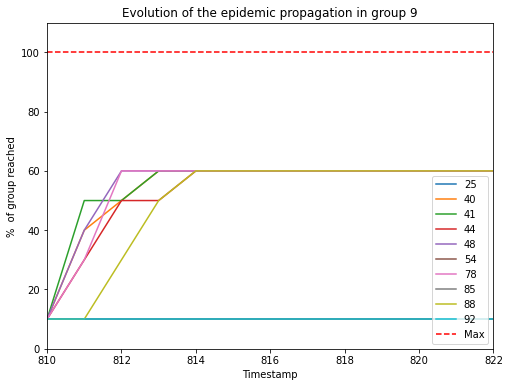

In [68]:
for group_id, perco in perco_group.items():
    plt.figure(figsize=(8,6))
    for sid, p in perco.items():
        plt.plot(p.keys(), p.values(), label=str(sid))
    plt.axhline(y=100, xmin=0, xmax=100, ls='--', c='red', label='Max')
    plt.xlabel('Timestamp')
    plt.ylabel('%  of group reached')
    plt.legend(loc='lower right')
    plt.xlim(start, start+12)
    plt.ylim(0,110)
    plt.title(f'Evolution of the epidemic propagation in group {group_id}')